In [ ]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


ModuleNotFoundError: No module named 'torch.nn'

# 3g Making Diffusion Curvature Density Invariant

- Take several densities of sampling of the saddle by linearly increasing n_points; plot diffusion curvature across the increasing dimension
    - Do both on ‘top’ and ‘bottom’; for space and its neural flattening.
    - Try subtracting and dividing the verticals, using “Subtraction” and “Ollivier” comparison_type.
        - Does
    - Try normalizing by density

**Hypothesis**: Diffusion Laziness will decrease as density increases. Comparing with a flattened space will negate this effect.

# Machinery

array([ 500.        ,  564.1025641 ,  628.20512821,  692.30769231,
        756.41025641,  820.51282051,  884.61538462,  948.71794872,
       1012.82051282, 1076.92307692, 1141.02564103, 1205.12820513,
       1269.23076923, 1333.33333333, 1397.43589744, 1461.53846154,
       1525.64102564, 1589.74358974, 1653.84615385, 1717.94871795,
       1782.05128205, 1846.15384615, 1910.25641026, 1974.35897436,
       2038.46153846, 2102.56410256, 2166.66666667, 2230.76923077,
       2294.87179487, 2358.97435897, 2423.07692308, 2487.17948718,
       2551.28205128, 2615.38461538, 2679.48717949, 2743.58974359,
       2807.69230769, 2871.79487179, 2935.8974359 , 3000.        ])

In [ ]:
from diffusion_curvature.datasets import rejection_sample_from_saddle
def compare_diffusion_curvature_across_densities(DC, dim=2, t = 25, graphformer = get_adaptive_graph):
    ns = np.linspace(500, 3000, 40).astype(int)
    ks = []
    for n in tqdm(ns):
        s = rejection_sample_from_saddle(n, dim)[0]
        g = graphformer(s)
        k = DC.curvature(
            g, t = t, dim=dim
        )
        ks.append(k[0])
    plt.plot(ns, ks)
    plt.title(f"Diffusion Curvature with {t=} in {dim=} over increasing densities")
    plt.xlabel("Num Points")
    return ks

# Results

In [ ]:
from functools import partial
graphformer = graphtools_graph_from_data

In [ ]:
X, ks = rejection_sample_from_saddle(2000, intrinsic_dim=2)
G = graphformer(X)

In [ ]:
DC = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    verbose=False,
    graph_former=graphformer
)

In [ ]:
k = DC.curvature(G, dim=2, t=25)

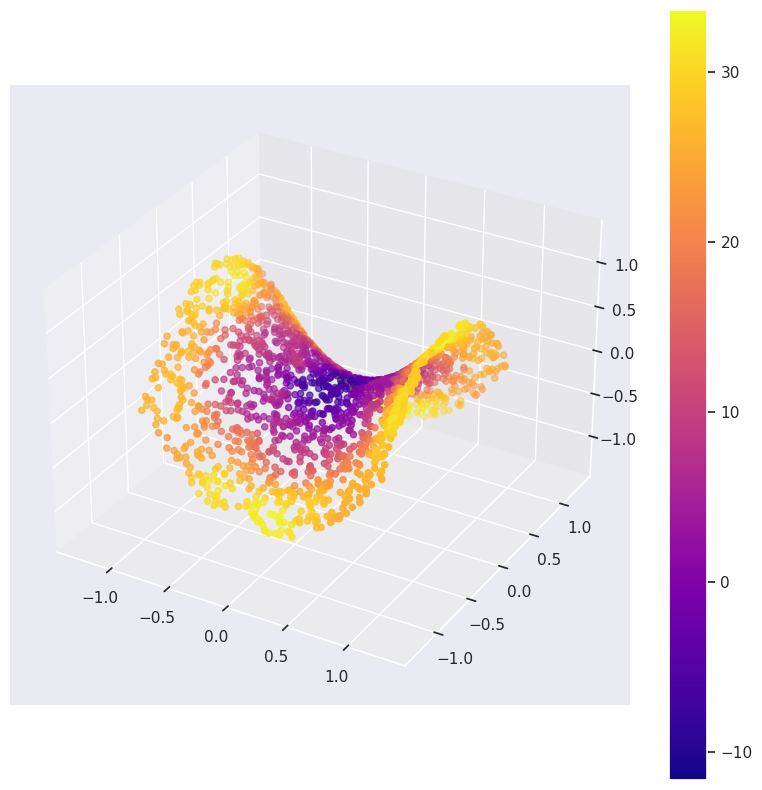

In [ ]:
plot_3d(X,k, colorbar=True)

  0%|          | 0/40 [00:00<?, ?it/s]

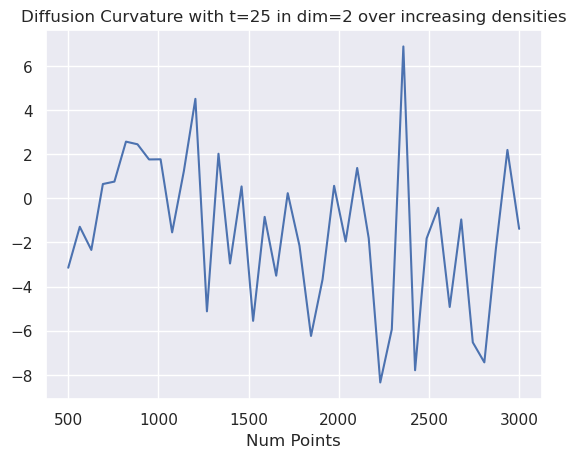

In [ ]:
ks_over_time = compare_diffusion_curvature_across_densities(DC, dim = 2, graphformer=graphformer)

  0%|          | 0/40 [00:00<?, ?it/s]

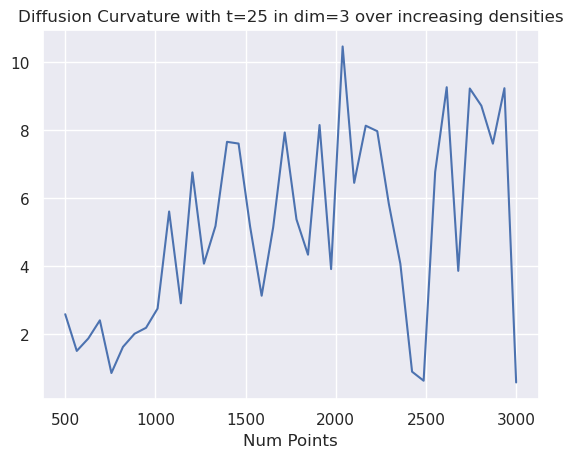

In [ ]:
ks_over_time = compare_diffusion_curvature_across_densities(DC, dim = 3, graphformer=graphformer)

## With Radial Flattening

In [ ]:
DC = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Radial Flattening",
    comparison_method="Subtraction",
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    verbose=False,
    graph_former=graphformer
)

In [ ]:
DC.curvature(G, t=25, dim=2)

Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

  0%|          | 0/40 [00:00<?, ?it/s]

2024-03-22 15:20:59,188:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-22 15:20:59,404:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-22 15:20:59,699:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-22 15:21:00,081:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-22 15:21:00,573:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-22 15:21:01,176:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-22 15:21:01,906:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-22 15:21:02,799:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-22 15:21:03,873:[WARNING](pygsp.graphs.graph.che

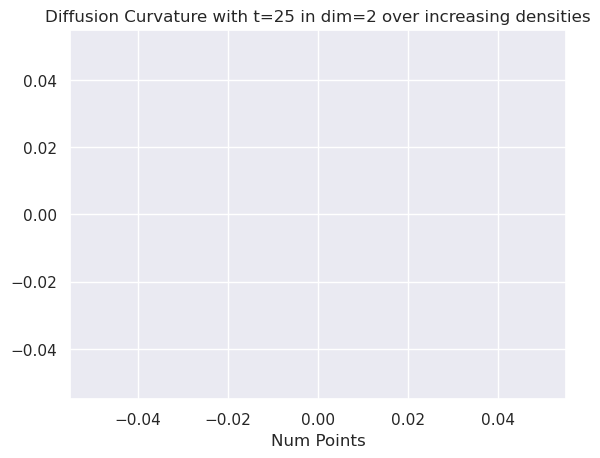

In [ ]:
ks_over_time = compare_diffusion_curvature_across_densities(DC, dim = 2)

# Conclusion